In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

In [11]:
columns= inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


2016-08-23


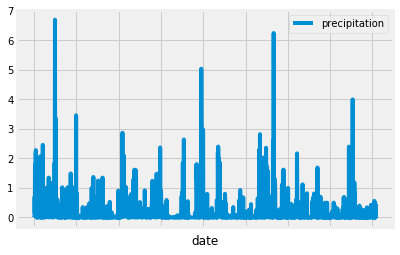

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

date_results = session.query(Measurement.date).order_by(Measurement.date).all()
#for i in date_results:
    #print(i)
# Calculate the date 1 year ago from the last data point in the database
dt1=date_results[-1][0]
datesplit=dt1.split("-")
j=str(int(datesplit[0]) -1)
enddate=(j + "-"+ datesplit[1] +"-"+datesplit[2])
print(enddate)
# Perform a query to retrieve the data and precipitation scores
results2=session.query(Measurement.date, Measurement.prcp).filter (Measurement.date>=enddate).filter(Measurement.date <=dt1).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain=pd.DataFrame(results2,columns=["date", "precipitation"])
rain.dropna(inplace=True) 
rain.set_index("date",inplace=True)                                  
# Sort the dataframe by date
rain.sort_index(inplace=True)
rain
# Use Pandas Plotting with Matplotlib to plot the data
rain.plot()

![precipitation](Images/precipitation.png)

In [14]:
rain.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
stat1=session.query(Station.station).count()
print(stat1)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat2=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for i in stat2:
    print(i)
    







('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stat2=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station='USC00519281').all()

print(stat2)

[(54.0, 85.0, 71.66378066378067)]


('USC00519281',)


Text(0, 0.5, 'Frequency')

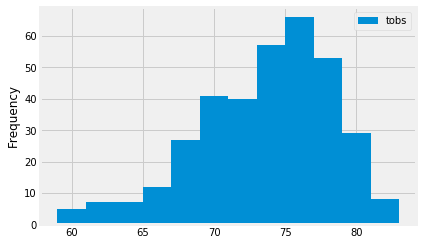

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#stat3=session.query(Measurement.tobs,func.count(Measurement.tobs).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

stat3=session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
                    
print(stat3)  

temp_yr=session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=enddate).filter(Measurement.date <=dt1).filter_by(station='USC00519281').all()
                                                                 
temperature_df=pd.DataFrame(temp_yr,columns=["date", "tobs"])
temperature_df.set_index('date', inplace=True)                   
temperature_df.sort_index(inplace=True)
plt.hist(temperature_df['tobs'], bins=12, label='tobs')
plt.legend(loc='best')
plt.ylabel('Frequency')






![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date='2016-06-15'
end_date='2016-06-25'
print(calc_temps(start_date,end_date))

[(69.0, 75.88888888888889, 80.0)]


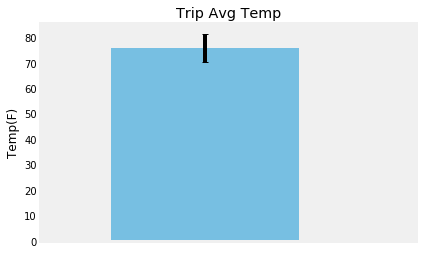

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, tavg, tmax=calc_temps(start_date, end_date)[0]


xvariable=np.arange(1)
avgtemp=[tavg]
error=[]
error.append((np.std([tmin,tmax])))
plt.bar(xvariable, avgtemp, yerr=error, align='center', alpha=.5, capsize=3)
plt.xlim(-.7, .9)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp(F)")
plt.grid()



In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-06-15'
end_date = '2016-06-25'

raindata = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(raindata)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.6800000000000015), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.3000000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.9600000000000002), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.59), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.6), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.58), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.11)]


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
